In [1]:
!pip install mitsuba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 75.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import io
import tempfile
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import drjit as dr
import mitsuba as mi
print(mi.variants())
mi.set_variant("cuda_ad_rgb")

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [3]:
theta_max = np.deg2rad(20.0)

*Create mesh*

In [4]:
vertices = np.array([
    [-1.0, -1.0, 0.0],
    [ 1.0, -1.0, 0.0],
    [ 1.0,  1.0, 0.0],
    [-1.0,  1.0, 0.0],
], dtype=np.float32)

faces = np.array([
    [0, 1, 2],
    [0, 2, 3]
], dtype=np.int32)

*Create PLY string to be saved*

In [5]:
def create_ply_content(vertices, faces):
    """Create the content of a PLY file in ASCII format."""
    ply_content = io.StringIO()

    # Header PLY
    ply_content.write("ply\n")
    ply_content.write("format ascii 1.0\n")
    ply_content.write(f"element vertex {len(vertices)}\n")
    ply_content.write("property float x\n")
    ply_content.write("property float y\n")
    ply_content.write("property float z\n")
    ply_content.write(f"element face {len(faces)}\n")
    ply_content.write("property list uchar int vertex_index\n")
    ply_content.write("end_header\n")

    # Vertices
    for v in vertices:
        ply_content.write(f"{v[0]} {v[1]} {v[2]}\n")

    # Faces (triangles)
    for f in faces:
        ply_content.write(f"3 {f[0]} {f[1]} {f[2]}\n")

    return ply_content.getvalue()

# Generate the PLY string
ply_content = create_ply_content(vertices, faces)

*Write a file with the PLY mesh*

In [6]:
with tempfile.NamedTemporaryFile(mode='w', suffix='.ply', delete=False) as f:
    f.write(ply_content)
    temp_file_path = f.name

*Create the scene*

In [7]:
scene_dict = {
    "type": "scene",
    "square": {
        "type": "ply",
        "filename": temp_file_path,
        "face_normals": True  # Use vertex normals from file
    }
}

scene = mi.load_dict(scene_dict)

*Ray origins*

In [8]:
import numpy as np

# ---------------------------------------------------------
# 1) Plane-wave parameters
# ---------------------------------------------------------

theta = np.deg2rad(30.0)   # incidence angle from +z
phi   = np.deg2rad(20.0)   # azimuth

k_dir = np.array([
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
   -np.cos(theta)
], dtype=np.float32)

k_dir /= np.linalg.norm(k_dir)

plane_center = np.array([0.0, 0.0, 5.0])  # source plane location

# Build transverse orthonormal basis (u_hat, v_hat)
# Choose a helper vector not parallel to k_dir
tmp = np.array([0.0, 0.0, 1.0])
if abs(np.dot(tmp, k_dir)) > 0.9:
    tmp = np.array([0.0, 1.0, 0.0])

u_hat = np.cross(k_dir, tmp)
u_hat /= np.linalg.norm(u_hat)

v_hat = np.cross(k_dir, u_hat)

# ---------------------------------------------------------
# 2) Cartesian grid on the source plane
# ---------------------------------------------------------

Nx, Ny = 20, 20
n_rays = Nx * Ny  # This gives 400
Wx, Wy = 4.0, 4.0

x = np.linspace(-Wx / 2, Wx / 2, Nx)
y = np.linspace(-Wy / 2, Wy / 2, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

plane_center = np.array([0.0, 0.0, 5.0], dtype=np.float32)

ray_origins = (
    plane_center[None, None, :]
    + X[..., None] * u_hat[None, None, :]
    + Y[..., None] * v_hat[None, None, :]
)

ray_origins = ray_origins.reshape(-1, 3)

directions = np.repeat(k_dir[None, :], ray_origins.shape[0], axis=0)

dS = (Wx / (Nx - 1)) * (Wy / (Ny - 1))
ray_weights = np.full(ray_origins.shape[0], dS)

*Batch ray tracing - first first intersections*

In [9]:
# ------------------------------------------------------------
# Convert NumPy arrays → Mitsuba vectorized types
# ------------------------------------------------------------

ray_origins_mi = mi.Point3f(
    mi.Float(ray_origins[:, 0].astype(np.float32)),
    mi.Float(ray_origins[:, 1].astype(np.float32)),
    mi.Float(ray_origins[:, 2].astype(np.float32)),
)

directions_mi = mi.Vector3f(
    mi.Float(directions[:, 0].astype(np.float32)),
    mi.Float(directions[:, 1].astype(np.float32)),
    mi.Float(directions[:, 2].astype(np.float32)),
)

# ------------------------------------------------------------
# Create ray batch (NOW VALID)
# ------------------------------------------------------------

rays = mi.Ray3f(ray_origins_mi, directions_mi)
rays.maxt = mi.Float(np.inf)

# Batch intersection test
intersections = scene.ray_intersect(rays)

# Process results
valid_mask    = intersections.is_valid()
hit_points    = intersections.p

*Reflected rays*

In [10]:
normals = intersections.n

# Safe normalization of normals (handle zero-length normals)
normal_length = dr.sqrt(dr.squared_norm(normals))
safe_normals = dr.select(
    normal_length > 1e-6,
    dr.normalize(normals),
    mi.Vector3f(0.0, 0.0, 1.0)  # fallback normal
)

# Compute reflected directions
reflected_dirs = directions_mi - 2.0 * dr.dot(directions_mi, safe_normals) * safe_normals
reflected_dirs = dr.normalize(reflected_dirs)

# Ensure reflected direction is not zero
reflected_length = dr.sqrt(dr.squared_norm(reflected_dirs))
reflected_dirs = dr.select(
    reflected_length > 1e-6,
    dr.normalize(reflected_dirs),
    mi.Vector3f(0.0, 0.0, 1.0)
)

# Create reflected rays
reflected_ray_origins = hit_points + 1e-4 * normals
reflected_rays = mi.Ray3f(reflected_ray_origins, reflected_dirs)
reflected_rays.maxt = mi.Float(np.inf)

*Print some results*

In [11]:
print_results = 10
print(f"\nFirst {print_results} ray results:")

# Get numpy arrays and reshape
directions_np = np.array(directions).reshape(-1, 3)
hit_points_np = np.array(hit_points).reshape(-1, 3)
normals_np = np.array(normals).reshape(-1, 3)
reflected_dirs_np = np.array(reflected_dirs).reshape(-1, 3)
valid_mask_np = np.array(valid_mask)

for i in range(min(print_results, n_rays)):
    print(f"\nRay {i}:")
    if not valid_mask_np[i]:
        print("  No intersection")
        continue

    print(f"  HIT")
    print(f"  Direction   : [{directions_np[i, 0]:.4f}, {directions_np[i, 1]:.4f}, {directions_np[i, 2]:.4f}]")
    print(f"  Hit point   : [{hit_points_np[i, 0]:.4f}, {hit_points_np[i, 1]:.4f}, {hit_points_np[i, 2]:.4f}]")
    print(f"  Normal      : [{normals_np[i, 0]:.4f}, {normals_np[i, 1]:.4f}, {normals_np[i, 2]:.4f}]")

    # Show reflection physics
    dot_product = np.dot(directions_np[i], normals_np[i])
    print(f"  Dot product : {dot_product:.4f}")
    print(f"  Reflection  : [{reflected_dirs_np[i, 0]:.4f}, {reflected_dirs_np[i, 1]:.4f}, {reflected_dirs_np[i, 2]:.4f}]")



First 10 ray results:

Ray 0:
  No intersection

Ray 1:
  No intersection

Ray 2:
  No intersection

Ray 3:
  No intersection

Ray 4:
  No intersection

Ray 5:
  No intersection

Ray 6:
  No intersection

Ray 7:
  No intersection

Ray 8:
  No intersection

Ray 9:
  No intersection


*Statistics*

In [12]:
# FIX: Convert drjit scalar to Python int
valid_count_scalar = dr.sum(dr.select(valid_mask, 1, 0))
valid_count = int(valid_count_scalar[0]) if hasattr(valid_count_scalar, '__getitem__') else int(valid_count_scalar)

print(f"\n=== Statistics ===")
print(f"Total rays: {ray_origins.shape[0]}")
print(f"Intersections: {valid_count}")
print(f"Misses: {ray_origins.shape[0] - valid_count}")
print(f"Hit rate: {valid_count/ray_origins.shape[0]*100:.1f}%")

# Second bounce intersections
second_intersections = scene.ray_intersect(reflected_rays)
second_valid_mask = second_intersections.is_valid()
second_valid_count_scalar = dr.sum(dr.select(second_valid_mask, 1, 0))
second_valid_count = int(second_valid_count_scalar[0]) if hasattr(second_valid_count_scalar, '__getitem__') else int(second_valid_count_scalar)
print(f"Second bounce hits: {second_valid_count}")


=== Statistics ===
Total rays: 400
Intersections: 20
Misses: 380
Hit rate: 5.0%
Second bounce hits: 0


*Remove temporary file*

In [13]:
os.unlink(temp_file_path)

print("\nDone! GPU ray tracing completed successfully.")


Done! GPU ray tracing completed successfully.


*Visualization*

Valid intersections: 20 / 400


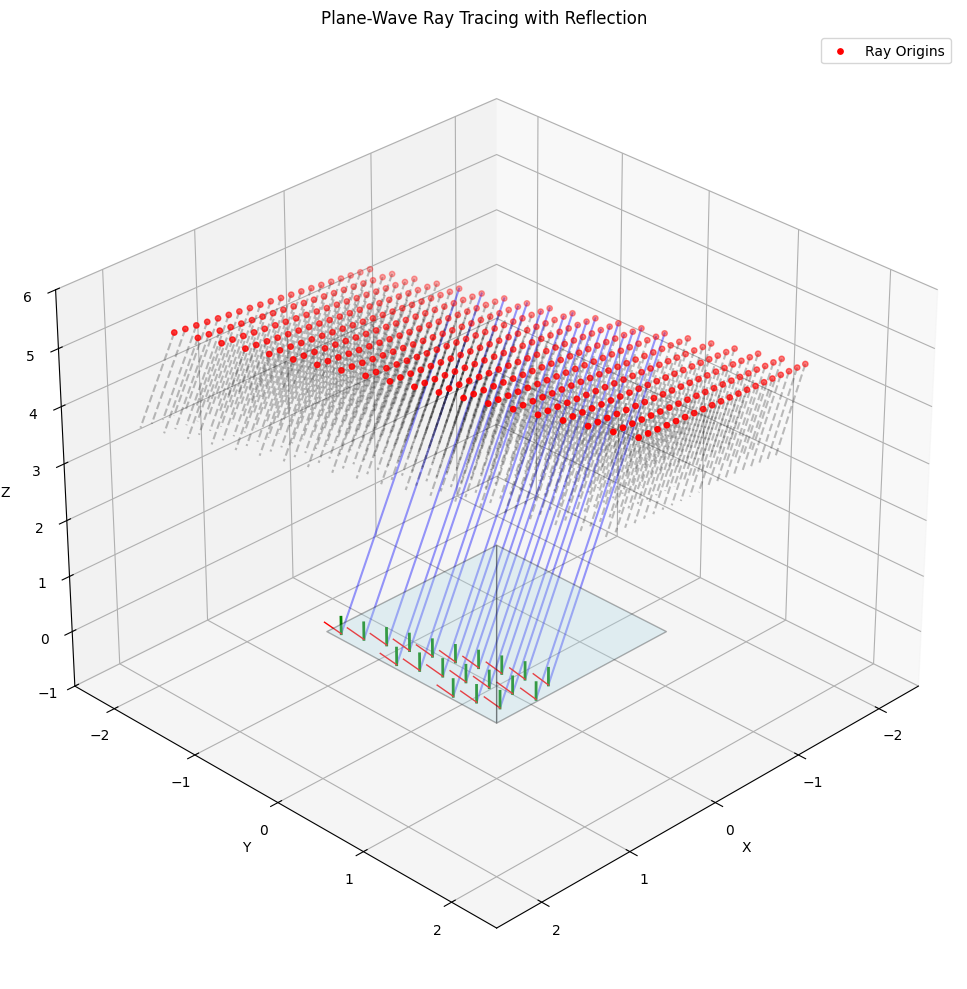

In [14]:
# ============================================================
# Visualization — plane-wave ray origins (CORRECTED)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ------------------------------------------------------------
# 1. Helper: force array into (N, 3)
# ------------------------------------------------------------

def force_Nx3(arr, name):
    arr = np.asarray(arr, dtype=float)

    if arr.ndim == 1 and arr.size % 3 == 0:
        arr = arr.reshape(-1, 3)
    elif arr.ndim == 2 and arr.shape[0] == 3 and arr.shape[1] != 3:
        arr = arr.T
    elif arr.ndim == 3:
        arr = arr.reshape(-1, 3)

    if arr.ndim != 2 or arr.shape[1] != 3:
        raise ValueError(f"{name} cannot be coerced to shape (N, 3), got {arr.shape}")

    return arr


# ------------------------------------------------------------
# 2. Convert Mitsuba arrays → NumPy
# ------------------------------------------------------------

ray_origins_np    = force_Nx3(ray_origins, "ray_origins")
directions_np     = force_Nx3(directions, "directions")
hit_points_np     = force_Nx3(hit_points, "hit_points")
normals_np        = force_Nx3(normals, "normals")
reflected_dirs_np = force_Nx3(reflected_dirs, "reflected_dirs")

valid_mask_np = np.asarray(valid_mask, dtype=bool).reshape(-1)

# Enforce consistent ray count
n_rays = min(
    ray_origins_np.shape[0],
    directions_np.shape[0],
    hit_points_np.shape[0],
    normals_np.shape[0],
    reflected_dirs_np.shape[0],
    valid_mask_np.shape[0],
)

ray_origins_np    = ray_origins_np[:n_rays]
directions_np     = directions_np[:n_rays]
hit_points_np     = hit_points_np[:n_rays]
normals_np        = normals_np[:n_rays]
reflected_dirs_np = reflected_dirs_np[:n_rays]
valid_mask_np     = valid_mask_np[:n_rays]

valid_idx = np.where(valid_mask_np)[0]
miss_idx  = np.where(~valid_mask_np)[0]

hit_v     = hit_points_np[valid_idx]
normals_v = normals_np[valid_idx]
refl_v    = reflected_dirs_np[valid_idx]

print(f"Valid intersections: {hit_v.shape[0]} / {n_rays}")

# ------------------------------------------------------------
# 3. Visualization
# ------------------------------------------------------------

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Plane-Wave Ray Tracing with Reflection")

# Mesh
mesh_triangles = [vertices[f] for f in faces]
mesh = Poly3DCollection(
    mesh_triangles,
    alpha=0.3,
    facecolor='lightblue',
    edgecolor='k'
)
ax.add_collection3d(mesh)

# Ray origins (camera plane)
ax.scatter(
    ray_origins_np[:, 0],
    ray_origins_np[:, 1],
    ray_origins_np[:, 2],
    color='red',
    s=15,
    label='Ray Origins'
)

# ------------------------------------------------------------
# 4. Incident rays (valid hits)
# ------------------------------------------------------------

for j, i in enumerate(valid_idx):
    p0 = ray_origins_np[i]
    p1 = hit_v[j]

    ax.plot(
        [p0[0], p1[0]],
        [p0[1], p1[1]],
        [p0[2], p1[2]],
        'b-', alpha=0.4
    )

    # Surface normal
    ax.plot(
        [p1[0], p1[0] + 0.3 * normals_v[j, 0]],
        [p1[1], p1[1] + 0.3 * normals_v[j, 1]],
        [p1[2], p1[2] + 0.3 * normals_v[j, 2]],
        'g-', linewidth=2
    )

    # Reflected ray
    ax.plot(
        [p1[0], p1[0] + 0.6 * refl_v[j, 0]],
        [p1[1], p1[1] + 0.6 * refl_v[j, 1]],
        [p1[2], p1[2] + 0.6 * refl_v[j, 2]],
        'r-', linewidth=1
    )

# ------------------------------------------------------------
# 5. Missed rays (optional, dashed)
# ------------------------------------------------------------

for i in miss_idx:  # limit for clarity
    p0 = ray_origins_np[i]
    p1 = p0 + 1.2 * directions_np[i]

    ax.plot(
        [p0[0], p1[0]],
        [p0[1], p1[1]],
        [p0[2], p1[2]],
        'k--', alpha=0.25
    )

# ------------------------------------------------------------
# 6. Axes and view
# ------------------------------------------------------------

ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
#ax.set_zlim([-1.0, 3.0])
ax.set_zlim([-1.0, 6.0])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()
ax.view_init(elev=30, azim=45)
#ax.view_init(elev=20, azim=10)


plt.tight_layout()
plt.show()
